In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import utm
import time
from datetime import datetime
from KalmanFilter import KalmanFilter
from math import sqrt
import copy
pd.set_option("display.max_rows", None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [53]:
def lat_log_posx_posy(df):
    pprint(df)
    dx = utm.from_latlon(df.latitude,df.longitude)
    df.latitude = dx[0]
    df.longitude = dx[1]

In [54]:
def convertTime(times):
    pt = []
    for i in range(len(times.date_time)):
        pt.append(time.mktime(datetime.strptime(times.iloc[i].date_time,"%Y-%m-%d %H:%M:%S+%f").timetuple()))
    return pt

In [55]:
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

In [56]:
def calcSpeed(r1,r2):
    dt = r2['timestamp'] - r1['timestamp']
    dd = sqrt(((r2['y'] - r1['y'])**2)+((r2['x']-r1['x'])**2))
    return dd/dt

In [57]:
def calcDist(x1,y1,x2,y2):
    return sqrt(((y2-y1)**2)+((x2-x1)**2))

In [58]:
def level1(init_track,tracks):
    # get the measurment noise - The 'accuracy' is pulled from the data itself and im not sure if it acutally is the measurement noise
    # But, it seems reasonable enough and I have no other method of calculating this
    x_std = y_std = init_track['accuracy'].std()
    
    # If we have less than 3 data points we cant calculate acceleration
    if len(init_track.index) < 3:
        return pd.DataFrame(),tracks

    # Initial time delta
    dt1 = init_track.iloc[1,init_track.columns.get_loc('timestamp')] - init_track.iloc[0,init_track.columns.get_loc('timestamp')]

    # Loop through all data points once to calculate velocities and acceleration
    # Having these will allow us to prime the filter and get better predictions early in the track
    vx = []
    vy = []
    ax = []
    ay = []
    prev_row = None
    for i,r in init_track.iterrows():
        if prev_row is not None:
            dt = r['timestamp'] - prev_row['timestamp']
            vx.append((r['x'] - prev_row['x'])/dt)
            vy.append((r['y'] - prev_row['y'])/dt)
        if len(vx) > 1:
            ax.append((vx[-1] - vx[-2])/dt)
            ay.append((vy[-1] - vy[-2])/dt)
        prev_row = r        
    vx = np.array(vx)
    vy = np.array(vy)
    ax = np.array(ax)
    ay = np.array(ay)

    # Now run through all data points in the track again and generate the filter
    xerrors = []
    yerrors = []
    prev_row = None
    # Initialize filter with first time delta, initial acceleration, control noise and measurement noise 
    KF = KalmanFilter(dt1,ax[0], ay[0], max(ax.std(),ay.std()), x_std,y_std)
    for i,r in init_track.iterrows():
        if prev_row is not None:
            dt = r['timestamp'] - prev_row['timestamp']
            KF.set_dt(dt)
        pred,px,pp = KF.predict()
        u,ux,up = KF.update(np.array([[r['x']],[r['y']]]))
        prev_row = r
        xerrors.append(abs(u.item(0,0) - r['x']))
        yerrors.append(abs(u.item(1,0) - r['y']))

    # Calculate the error distribution between predictions and actual measurements
    # We will use this to determine whether another track matches this one
    xerrors = np.array(xerrors).std()
    yerrors = np.array(yerrors).std()

    # Check all other tracks for a match
    mtrack,tracks,match = matchTracks(KF,init_track,tracks,xerrors,yerrors)

    # If there is a mathcing track then recursively udate the model and look for additional mathces
    if match:
        mtrack,tracks = level1(mtrack,tracks)
    return mtrack,tracks

In [59]:
def matchTracks(KF,track0,tracks,xerrors,yerrors):
    match = False
    for j,track1 in enumerate(tracks):
        # Make a copy of the model each loop so X,P dont get updated for bad matches
        kf2 = copy.deepcopy(KF)

        # Do a quick sanity check before bothering with the filter
        # 45 m/s is about 100 mph
        if calcSpeed(track0.iloc[-1],track1.iloc[0]) > 45:
            continue
        
        # Get the timedelta between the last point of the init track and the first point of the potential match
        dt = track1.iloc[0,track1.columns.get_loc('timestamp')] - track0.iloc[-1,track0.columns.get_loc('timestamp')]
        kf2.set_dt(dt)

        # Use the generated model to predict the state at time dt
        pred,x,p = kf2.predict()

        # If the error of the prediction is within the 2 stdv's of the original model then consider it a match
        # We will then add this set of data points to the original set and reginerate the model with the updated pints
        if abs(x.item(0,0) - track1.iloc[0,track1.columns.get_loc('x')]) < xerrors and \
          abs(x.item(1,0) - track1.iloc[0,track1.columns.get_loc('y')]) < yerrors:
            track0 = pd.concat([track0,track1])
            tracks.pop(j)
            match = True
            break
    return track0,tracks,match

In [60]:
# Get the data
d1 = pd.read_csv("dataset1_gps.csv")
d2 = pd.read_csv("dataset2_gps.csv")
d3 = pd.read_csv("dataset3_gps.csv")

Tracks to match: 37


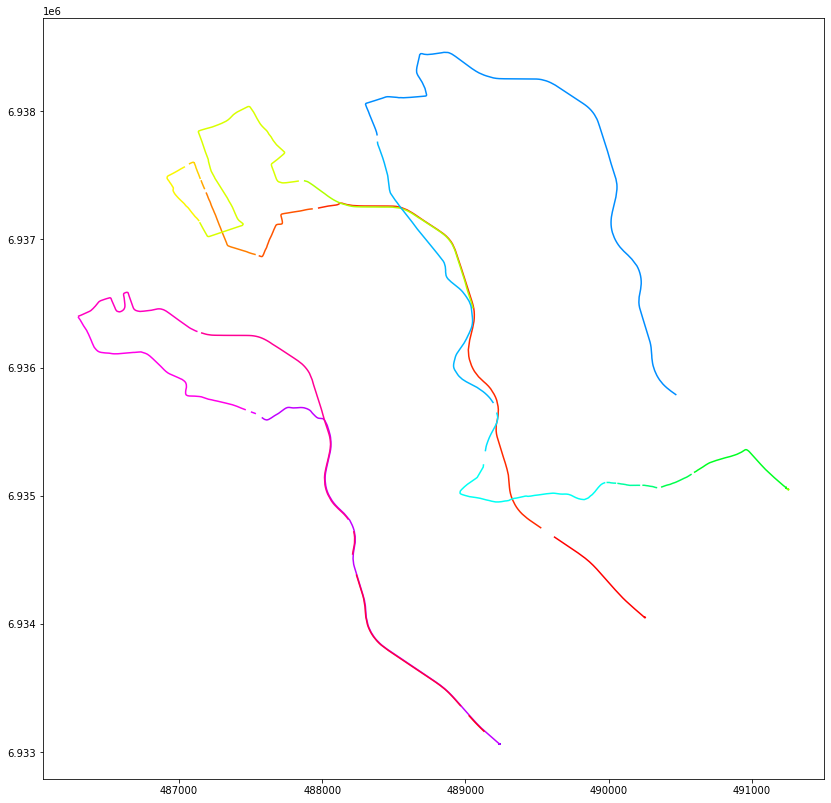

In [61]:

# Cut out 25% of the data
d1 = d1.sample(frac=.75,axis=0)
d2 = d2.sample(frac=.75,axis=0)
d3 = d3.sample(frac=.75,axis=0)

# Give each vehicle an id
# We will use this to check how well we preformed later on
d1['id'] = 1
d2['id'] = 2
d3['id'] = 3

# Sort by time after resampling
d1 = d1.sort_values(by=['timestamp'])
d2 = d2.sort_values(by=['timestamp'])
d3 = d3.sort_values(by=['timestamp'])

# Calculate time deltas between samples
d1['index'] = d1.index
d2['index'] = d2.index
d3['index'] = d3.index
d1['td'] = d1['index'].diff()
d2['td'] = d2['index'].diff()
d3['td'] = d3['index'].diff()

# Convert lat lon to cartesian
d1[['x','y']] = d1[['latitude','longitude']].apply(lambda x: utm.from_latlon(*x)[0:2],axis=1).to_list()
d2[['x','y']] = d2[['latitude','longitude']].apply(lambda x: utm.from_latlon(*x)[0:2],axis=1).to_list()
d3[['x','y']] = d3[['latitude','longitude']].apply(lambda x: utm.from_latlon(*x)[0:2],axis=1).to_list()

# Offset the data sets a little - these vehicles all used the same road initially so this makes things a little easier to visualize
d2['x'] = d2['x'] + 1000
d2['y'] = d2['y'] + 1000
d3['x'] = d3['x'] - 1000
d3['y'] = d3['y'] - 1000

# Create track object structures
dfs = [d1,d2,d3]
tracks = []
# For each data frame, break contigous sets of samples into tracks
# Allow for 3 missing measurement in a track (r['td] < 4.0)
for df in dfs:
    track = pd.DataFrame()
    for i,r in df.iterrows():
        if len(track.index) == 0:
            track = track.append(r)
        elif r['td'] < 4:
            track = track.append(r)
        else:
            tracks.append(track)
            track = pd.DataFrame()

# Plot the problem space
print(f'Tracks to match: {len(tracks)}')
plt.figure(figsize = (14,14))
cmap = get_cmap(len(tracks))
for i,track in enumerate(tracks):
    plt.plot(track['x'],track['y'],c=cmap(i))
plt.show()


Expecting three dataframes with one unique id each...
[1.]
[2.]
[3.]


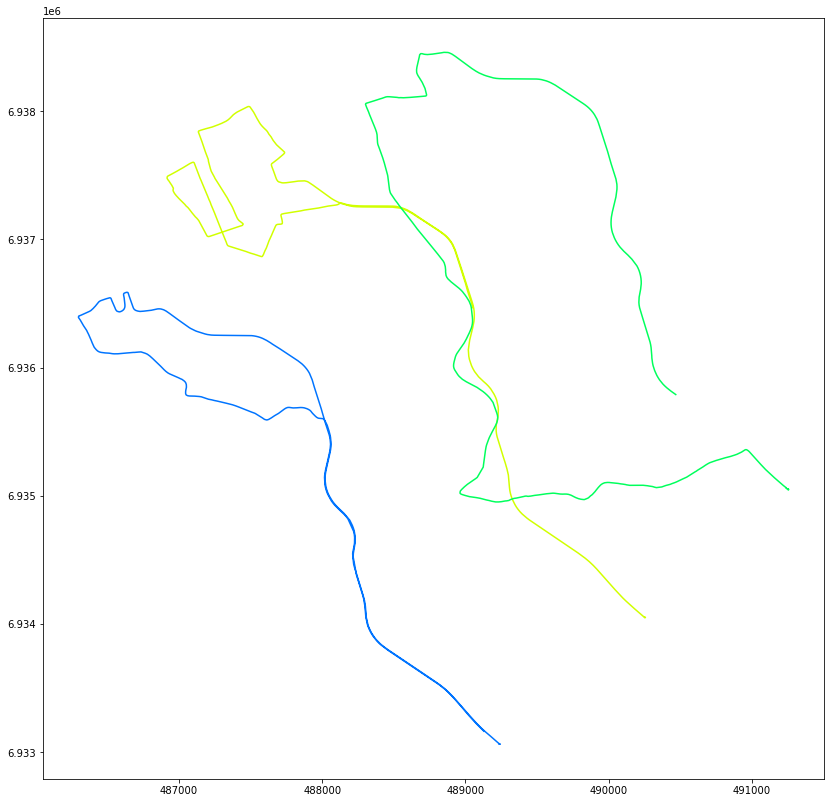

In [62]:
mTracks = []
mTrack = pd.DataFrame()

# Sort all tracks by time
tracks = sorted(tracks,key=lambda x: x.iloc[0,x.columns.get_loc('timestamp')])

# Main processing loops
while(len(tracks) > 1):
    mTrack,tracks = level1(tracks[0],tracks[1:])
    # If the match track has data then we have fully recursed and gathered all matching tracks possible
    # Add it to the list
    if len(mTrack.index) > 0:
        mTracks.append(mTrack)
    # Only one track left so just create a separate match track
    if len(tracks) == 1:
        mTracks.append(tracks[0])
plt.figure(figsize = (14,14))
cmap = get_cmap(len(mTracks)*2)
print('Expecting three dataframes with one unique id each...')
for i,track in enumerate(mTracks):
    # For each mtrack we should have only one unique id
    print(track.id.unique())
    if len(track.index):
        plt.plot(track['x'],track['y'],c=cmap(i+1))